In [1055]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics
import graphviz 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
import seaborn as sn

wine = pd.read_csv("./winequality-red.csv")

In [1056]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


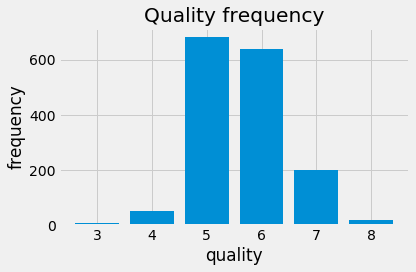

In [1057]:
quality_dist = wine['quality'].value_counts()
fig = plt.figure(tight_layout=True)

plt.bar(quality_dist.index, quality_dist)
plt.title("Quality frequency")
plt.xlabel('quality')
plt.ylabel('frequency')
fig.savefig('results/plots/quality_bar.png')
plt.show()

In [1058]:
wine['quality'].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

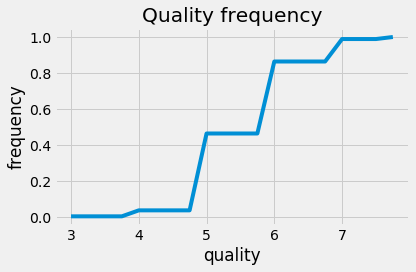

In [1059]:
values, base = np.histogram(wine['quality'], bins=20)
kumulativ = np.cumsum(values/wine.shape[0])
fig = plt.figure(tight_layout=True)
plt.plot(base[:-1], kumulativ)
plt.title("Quality frequency")
plt.xlabel('quality')
plt.ylabel('frequency')
fig.savefig('results/plots/quality_frequence.png')
plt.show()

In [1060]:
low_quality = wine.loc[wine['quality'] <= 6].index
high_quality = wine.loc[wine['quality'] > 6].index

wine.iloc[low_quality, wine.columns.get_loc('quality')] = 0
wine.iloc[high_quality, wine.columns.get_loc('quality')] = 1

# Dataset quality distribution

In [1061]:
wine['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

# Correlation heatmap

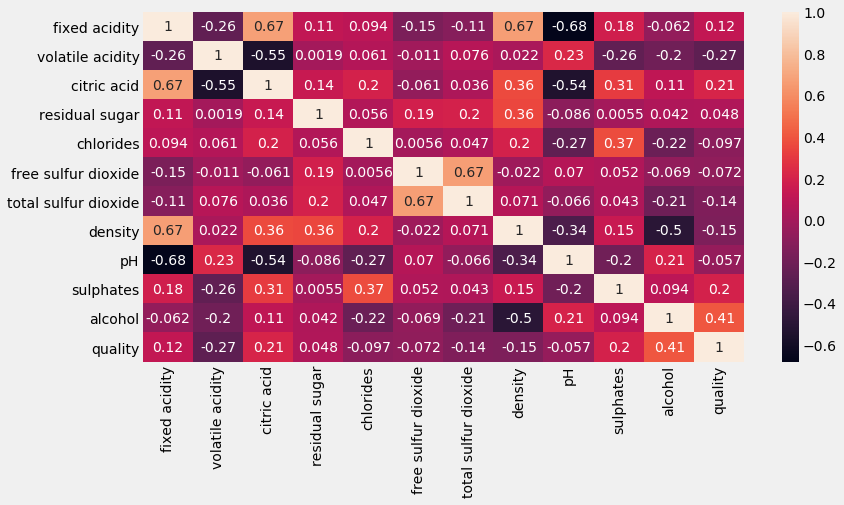

In [1062]:
df = pd.DataFrame(wine)

fig = plt.figure(figsize=(12,6))
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
fig.savefig('results/plots/corr_heatmap.png')

# Devide data and drop columns

In [1063]:
y = wine['quality']
x = wine.drop(['quality', 'residual sugar', 'pH', 'free sulfur dioxide'],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 42)

x.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4


# Decision tree

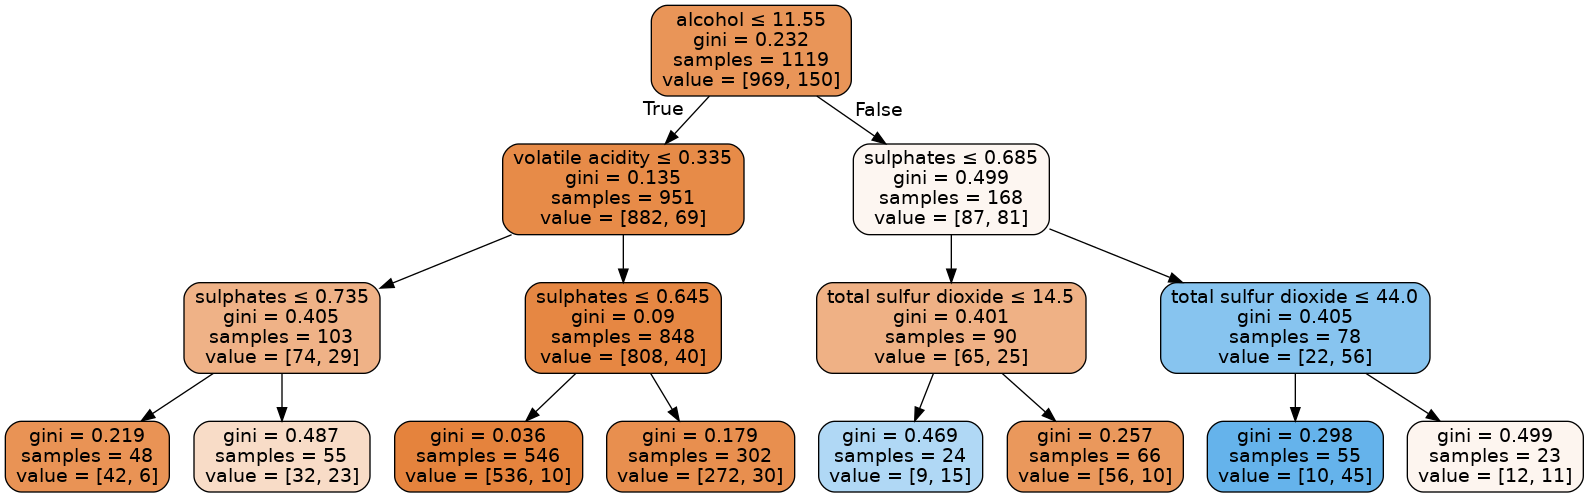

In [1064]:
dec_clf = tree.DecisionTreeClassifier(max_depth=3)
dec_clf.fit(x_train, y_train)
dec_pred = dec_clf.predict(x_test)

# Visualizing the decision tree
dot_data = StringIO()

tree.export_graphviz(
    dec_clf,
    out_file=dot_data,
    max_depth=3,
    feature_names=list(x.columns.values),
    filled=True,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('results/plots/decision_tree.png')
Image(graph.create_png())

### Confusion matrix

In [1065]:
dec_conf_mat = pd.DataFrame(confusion_matrix(y_test, dec_pred))
dec_conf_mat.to_csv(r'results/csv/dec_confusion_matrix.csv', index = True, header=True)
dec_conf_mat

,0,1
0,398,15
1,54,13


# KNN

In [1066]:
x.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4


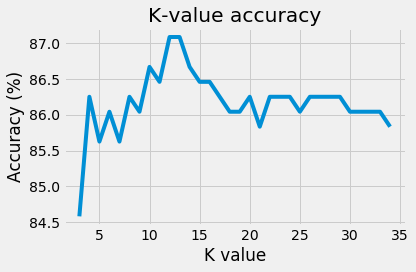

Max K-score is 87.08% with K-value 12 


In [1067]:
k_scores = []
k_range = range(3,35)

for k in k_range:
    knn_clf = KNeighborsClassifier(n_neighbors = k)

    knn_clf.fit(x_train, y_train)
    knn_pred=knn_clf.predict(x_test)
    k_scores.append(metrics.accuracy_score(y_test, knn_pred)*100)
        
max_knn_acc = max(k_scores)
max_knn_range = k_scores.index(max_knn_acc) + 3

fig = plt.figure(tight_layout=True)
plt.style.use('fivethirtyeight')
plt.title("K-value accuracy")
plt.xlabel("K value")
plt.ylabel("Accuracy (%)")
plt.plot(k_range, k_scores)
fig.savefig('results/plots/knn_k_scores.png')
plt.show()

print(f'Max K-score is {str(round(max_knn_acc, 2))}% with K-value {max_knn_range} ')


### Confusion matrix

In [1068]:
knn_conf_mat = pd.DataFrame(confusion_matrix(y_test, knn_pred))
knn_conf_mat.to_csv(r'results/csv/knn_confusion_matrix.csv', index = True, header=True)
#knn_conf_mat

,0,1
0,412,1
1,67,0


# Conclusion

In [1069]:
conc = pd.DataFrame({
    "Models": ["Decision tree", "KNN"],
    "Accuracy (%)":
        [
            str(round(metrics.accuracy_score(y_test, dec_pred) * 100, 2)),
            str(round(max_knn_acc, 2))
        ]
})

conc.to_csv(r'results/csv/conclusion.csv', index=False, header=True)
conc

,Models,Accuracy (%)
0,Decision tree,85.62
1,KNN,87.08
